In [2]:
from utils import *
import cv2
import numpy as np
import matplotlib.pyplot as plt

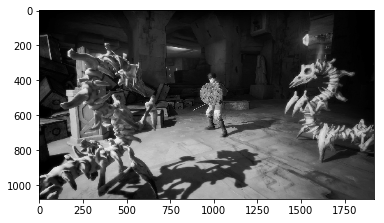

In [39]:
resample_gray = cv2.imread("resampled.png", cv2.IMREAD_GRAYSCALE)
plt.figure()
plt.imshow(resample_gray,cmap = "gray")

In [33]:
def apply_gaussian(input_img, sigma, kernel_half):
    img = np.copy(input_img)
    width, height = img.shape[1], img.shape[0]
    window_x = (int(width/8*3), width - int(width/8*3))
    window_y = (int(height/8*3), height - int(height/8*3))
    
    kernel = gaussian_kernel(sigma,kernel_half)
    
    vertical_left = img[window_y[0]:window_y[1], window_x[0]-kernel_half:window_x[0]+kernel_half]
    vertical_right = img[window_y[0]:window_y[1], window_x[1]-kernel_half:window_x[1]+kernel_half]
    horizontal_up = img[window_y[0]-kernel_half:window_y[0]+kernel_half, window_x[0]:window_x[1]]
    horizontal_down = img[window_y[1]-kernel_half:window_y[1]+kernel_half, window_x[0]: window_x[1]]
    
    blur_vertical_left = cv2.filter2D(vertical_left, -1, kernel)
    blur_vertical_right = cv2.filter2D(vertical_right, -1, kernel)
    blur_horizontal_up = cv2.filter2D(horizontal_up, -1, kernel)
    blur_horizontal_down = cv2.filter2D(horizontal_down, -1, kernel)
    
    img[window_y[0]:window_y[1], window_x[0]-kernel_half:window_x[0]+kernel_half] = blur_vertical_left
    img[window_y[0]:window_y[1], window_x[1]-kernel_half:window_x[1]+kernel_half] = blur_vertical_right
    img[window_y[0]-kernel_half:window_y[0]+kernel_half, window_x[0]:window_x[1]] = blur_horizontal_up
    img[window_y[1]-kernel_half:window_y[1]+kernel_half, window_x[0]: window_x[1]] = blur_horizontal_down
    
    return img
    

True

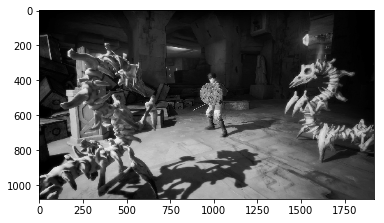

In [43]:
# modify here
sigma = 1
kernel_half = 10
new_img = apply_gaussian(resample_gray, sigma, kernel_half)
# print(np.where(new_img != resample_gray))
plt.figure()
plt.imshow(new_img,cmap="gray")
cv2.imwrite("results/gaussian_{}_{}.png".format(sigma,kernel_half),new_img)